# Comparison of optimization model variants

In this notebook different variants of storage model can be compared. Each variant uses a different approach to model the charging and discharging efficiency:
- [Linear Implementation](#linear-implementation-of-the-charging-and-discharging-efficiency)
    - [without storage losses](#linear-implementation-of-the-charging-and-discharging-efficiency-without-storage-losses)
    - [with storage losses](#linear-implementation-of-the-charging-and-discharging-efficiency-with-storage-losses)
- [Implementation using SOS 2 variables](#implementation-using-sos2-variables-of-the-charging-and-discharging-efficiency)
    - [without storage losses](#implementation-using-sos2-variables-of-the-charging-and-discharging-efficiency-without-storage-losses)
    - [with constant storage efficiency](#implementation-using-sos2-variables-of-the-charging-and-discharging-efficiency-with-constant-storage-efficiency)
    - [with soc dependent storage efficiency](#implementation-using-sos2-variables-of-the-charging-and-discharging-efficiency-with-soc-dependent-efficiency)
- [Implementation using a Big M approach](#implementation-using-a-big-m-approach-of-the-charging-and-discharging-efficiency)

To compare the variants a simple energy system set up is used. The energy system consists of two energy sources, one fixed (renewable) source with no costs and one flexible (fossil) source with associated costs. These sources need to satisfy a fixed energy demand. The storage can be used to time shift the renewable energy.

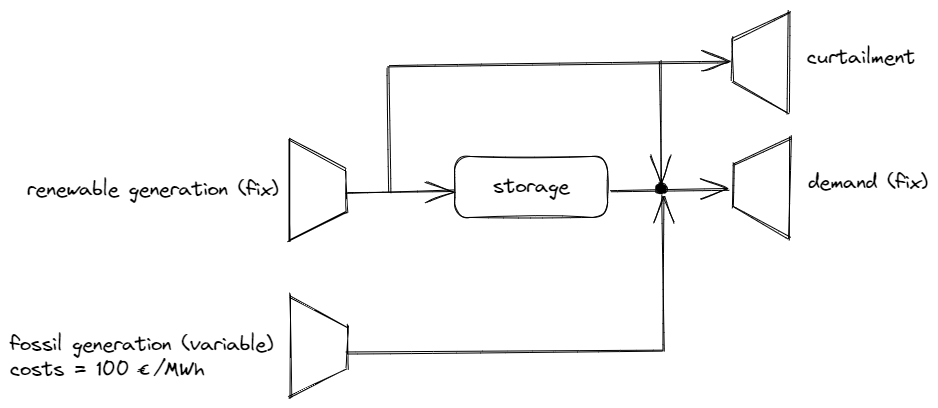

The code below can be used to compare the models either with the predefined data or your own data.

To choose your own data, simply change the .csv file at the beginning of each code section:

```python
# read scenarios that are to be calculated
scenario_file_name = "linear_model_caluclations.csv"
```
The [linear_model_caluclations.csv](data/linear_model_calculations.csv) contains all relevant parameters to optimize the linear energy system. "**;**" has to be chosen as separator, in order to correctly read the data from the file.

Each row in the .csv file corresponds to solving one optimization problem and is identified by a unique name, given in the columns *name*, and activated by setting *active* to 1.

By specifying *solve_timeout* and *mip_gap* the termination conditions for the solver are set. The keywords *start_date* and *timeseries_length* are used to construct the timeindex of the optimization problem and should correspond to the timeseries data for the optimization problem. The names of the .csv files containing this data is specified under the keyword *input_data* and should be saved in the folder *data*. The absolute values of the timeseries input data can be manipulated using the multipliers *sf_dem* and *sf_res* respectively: 

$data(t)=sf \cdot input\_data(t)$

With the remaining keywords the characteristics of the storage system are specified.

In the [sos2_model_calculations.csv](data/sos2_model_calculations.csv) and [big_m_model_calculations.csv](data/big_m_model_calculations.csv) instead of the keywords *ETA_IN* and *ETA_OUT* the breakpoints for the segments of the linearized efficiency curves *p_in_breakpoints*, *p_in_stor_breakpoints*, *p_out_breakpoints* and *p_out_stor_breakpoints* have to be given in the following form:

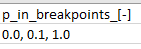

The breakpoints have to be given in ascending order and separated by a comma followed by a blank space.

To analyze the effect of the storage losses these can be specified with the keywords *ETA_SOC* or *SOC_LOSS_VAR* and *SOC_LOSS_FIX*, in [linear_model_caluclations.csv](data/linear_model_calculations.csv) and [sos2_model_calculations.csv](data/sos2_model_calculations.csv) respectively. While these keywords occur in both .csv-files, the respective values are only read and used in the energy system calculations requiring these parameters.

To choose a solver, change the name of the solver:

```python
# specify name of solver to used, e.g. cplex, gurobi, cbc, glpk, ...
solver_name = "cplex"
```

Additionally, specify where the results are to be saved, by adjusting the name and path:

```python
# set path to folder for results
export_folder_name = "results_linear_model_calculations_without_losses"
export_root = os.path.realpath(os.path.join(os.getcwd(), export_folder_name))
```



# Linear Implementation of the charging and discharging efficiency

## Linear Implementation of the charging and discharging efficiency without storage losses

In [3]:
import os
from energy_system.calculate_energy_system_linear import (
    read_scenario_file,
    set_up_energy_system_model,
    process_solver_results,
    export_scenario_description,
)

# ------------------------------------------------------------------------------
# Feel free to change to use your own data, solver, folder system...
# ------------------------------------------------------------------------------

# set path to folder for results
export_folder_name = "results_phs_linear_calculations_without_losses"
export_root = os.path.realpath(os.path.join(os.getcwd(), "results", export_folder_name))

# create export directory if necessary
if not os.path.exists(export_root):
    os.makedirs(export_root)

# read scenarios that are to be calculated
scenario_file_name = "phs_linear_calculations.csv"
scenario_file = os.path.realpath(os.path.join(os.getcwd(), "data", scenario_file_name))
scenario_options, scenario_status = read_scenario_file(scenario_file)

# specify name of solver to used, e.g. cplex, gurobi, cbc, glpk, ...
solver_name = "cplex"

# ------------------------------------------------------------------------------
# Change only, if you know what you are doing
# ------------------------------------------------------------------------------

# loop over scenarios
for i_scenario in scenario_options.index:
    # skip inactive scenarios
    if not scenario_options.at[i_scenario, "active"]:
        continue

    model = set_up_energy_system_model(scenario_options, i_scenario)

    # solve problem using solver
    solver_results = model.solve(
        solver=solver_name,
        solve_kwargs={"tee": False},
        cmdline_options={
            "timelimit": scenario_options.at[i_scenario, "solve_timeout"],
            "mipgap": scenario_options.at[i_scenario, "mip_gap"],
        },
    )

    process_solver_results(
        solver_results,
        model,
        scenario_status,
        i_scenario,
        export_root,
        scenario_options,
    )

export_scenario_description(export_root, scenario_status)


[2023-07-24 17:01:29]	Calculating scenario: 'phs_winter_max_eff'
[2023-07-24 17:01:30]	Scenario: 'phs_winter_max_eff' finished .
[2023-07-24 17:01:30]	Calculating scenario: 'phs_winter_mean_eff'
[2023-07-24 17:01:31]	Scenario: 'phs_winter_mean_eff' finished .
[2023-07-24 17:01:31]	Calculating scenario: 'phs_winter_reg_eff'
[2023-07-24 17:01:32]	Scenario: 'phs_winter_reg_eff' finished .
[2023-07-24 17:01:32]	Calculating scenario: 'phs_sommer_max_eff'
[2023-07-24 17:01:33]	Scenario: 'phs_sommer_max_eff' finished .
[2023-07-24 17:01:33]	Calculating scenario: 'phs_sommer_mean_eff'
[2023-07-24 17:01:34]	Scenario: 'phs_sommer_mean_eff' finished .
[2023-07-24 17:01:34]	Calculating scenario: 'phs_sommer_reg_eff'
[2023-07-24 17:01:35]	Scenario: 'phs_sommer_reg_eff' finished .
[2023-07-24 17:01:35]	Calculated all scenarios.


## Linear Implementation of the charging and discharging efficiency with storage losses

In [ ]:
import os
from energy_system.calculate_energy_system_linear_with_storage_losses import (
    read_scenario_file,
    set_up_energy_system_model,
    process_solver_results,
    export_scenario_description,
)

# ------------------------------------------------------------------------------
# Feel free to change to use your own data, solver, folder system...
# ------------------------------------------------------------------------------

# set path to folder for results
export_folder_name = "results_caes_linear_calculations_with_losses"
export_root = os.path.realpath(os.path.join(os.getcwd(), "results", export_folder_name))

# create export directory if necessary
if not os.path.exists(export_root):
    os.makedirs(export_root)

# read scenarios that are to be calculated
scenario_file_name = "caes_linear_calculations_with_losses.csv"
scenario_file = os.path.realpath(os.path.join(os.getcwd(), "data", scenario_file_name))
scenario_options, scenario_status = read_scenario_file(scenario_file)

# specify name of solver to used, e.g. cplex, gurobi, cbc, glpk, ...
solver_name = "cplex"

# ------------------------------------------------------------------------------
# Change only, if you know what you are doing
# ------------------------------------------------------------------------------

# loop over scenarios
for i_scenario in scenario_options.index:
    # skip inactive scenarios
    if not scenario_options.at[i_scenario, "active"]:
        continue

    model = set_up_energy_system_model(scenario_options, i_scenario)

    # solve problem using solver
    solver_results = model.solve(
        solver=solver_name,
        solve_kwargs={"tee": False},
        cmdline_options={
            "timelimit": scenario_options.at[i_scenario, "solve_timeout"],
            "mipgap": scenario_options.at[i_scenario, "mip_gap"],
        },
    )

    process_solver_results(
        solver_results,
        model,
        scenario_status,
        i_scenario,
        export_root,
        scenario_options,
    )

export_scenario_description(export_root, scenario_status)


# Implementation using SOS2 variables of the charging and discharging efficiency

## Implementation using SOS2 variables of the charging and discharging efficiency without storage losses

In [ ]:
import os
from energy_system.calculate_energy_system_sos2 import (
    read_scenario_file,
    set_up_energy_system_model,
    process_solver_results,
    export_scenario_description,
)

# ------------------------------------------------------------------------------
# Feel free to change to use your own data, solver, folder system...
# ------------------------------------------------------------------------------

# set path to folder for results
export_folder_name = "results_sos2_model_calculations_without_losses"
export_root = os.path.realpath(os.path.join(os.getcwd(), "results", export_folder_name))

# create export directory if necessary
if not os.path.exists(export_root):
    os.makedirs(export_root)

# read scenarios that are to be calculated
scenario_file_name = "sos2_model_calculations_without_losses.csv"
scenario_file = os.path.realpath(os.path.join(os.getcwd(), "data", scenario_file_name))
scenario_options, scenario_status = read_scenario_file(scenario_file)

# specify name of solver to used, e.g. cplex, gurobi, cbc, glpk, ...
solver_name = "cplex"

# ------------------------------------------------------------------------------
# Change only, if you know what you are doing
# ------------------------------------------------------------------------------

# loop over scenarios
for i_scenario in scenario_options.index:
    # skip inactive scenarios
    if not scenario_options.at[i_scenario, "active"]:
        continue

    model = set_up_energy_system_model(scenario_options, i_scenario)

    # solve problem using solver
    solver_results = model.solve(
        solver=solver_name,
        solve_kwargs={"tee": False},
        cmdline_options={
            "timelimit": scenario_options.at[i_scenario, "solve_timeout"],
            "mipgap": scenario_options.at[i_scenario, "mip_gap"],
        },
    )

    process_solver_results(
        solver_results, model, scenario_status, i_scenario, export_root
    )

export_scenario_description(export_root, scenario_status)


## Implementation using SOS2 variables of the charging and discharging efficiency with constant storage efficiency

In [7]:
import os
from energy_system.calculate_energy_system_sos2_with_constant_storage_efficiency import (
    read_scenario_file,
    set_up_energy_system_model,
    process_solver_results,
    export_scenario_description,
)

# ------------------------------------------------------------------------------
# Feel free to change to use your own data, solver, folder system...
# ------------------------------------------------------------------------------

# set path to folder for results
export_folder_name = "results_caes_sos2_calculations_with_constant_losses"
export_root = os.path.realpath(os.path.join(os.getcwd(), "results", export_folder_name))

# create export directory if necessary
if not os.path.exists(export_root):
    os.makedirs(export_root)

# read scenarios that are to be calculated
scenario_file_name = "caes_sos2_calculations_with_constant_losses.csv"
scenario_file = os.path.realpath(os.path.join(os.getcwd(), "data", scenario_file_name))
scenario_options, scenario_status = read_scenario_file(scenario_file)

# specify name of solver to used, e.g. cplex, gurobi, cbc, glpk, ...
solver_name = "cplex"

# ------------------------------------------------------------------------------
# Change only, if you know what you are doing
# ------------------------------------------------------------------------------

# loop over scenarios
for i_scenario in scenario_options.index:
    # skip inactive scenarios
    if not scenario_options.at[i_scenario, "active"]:
        continue

    model = set_up_energy_system_model(scenario_options, i_scenario)

    # solve problem using solver
    solver_results = model.solve(
        solver=solver_name,
        solve_kwargs={"tee": False},
        cmdline_options={
            "timelimit": scenario_options.at[i_scenario, "solve_timeout"],
            "mipgap": scenario_options.at[i_scenario, "mip_gap"],
        },
    )

    process_solver_results(
        solver_results, model, scenario_status, i_scenario, export_root
    )

export_scenario_description(export_root, scenario_status)


[2023-07-24 16:53:07]	Calculating scenario: 'caes_winter_2_sections'
[2023-07-24 16:53:09]	Scenario: 'caes_winter_2_sections' finished .
[2023-07-24 16:53:09]	Calculating scenario: 'caes_winter_3_sections'
[2023-07-24 16:53:11]	Scenario: 'caes_winter_3_sections' finished .
[2023-07-24 16:53:11]	Calculating scenario: 'caes_winter_4_sections'
[2023-07-24 16:53:13]	Scenario: 'caes_winter_4_sections' finished .
[2023-07-24 16:53:13]	Calculating scenario: 'caes_winter_5_sections'
[2023-07-24 16:53:15]	Scenario: 'caes_winter_5_sections' finished .
[2023-07-24 16:53:15]	Calculating scenario: 'caes_winter_6_sections'
[2023-07-24 16:53:17]	Scenario: 'caes_winter_6_sections' finished .
[2023-07-24 16:53:17]	Calculating scenario: 'caes_sommer_2_sections'
[2023-07-24 16:53:19]	Scenario: 'caes_sommer_2_sections' finished .
[2023-07-24 16:53:19]	Calculating scenario: 'caes_sommer_3_sections'
[2023-07-24 16:53:20]	Scenario: 'caes_sommer_3_sections' finished .
[2023-07-24 16:53:20]	Calculating scenari

## Implementation using SOS2 variables of the charging and discharging efficiency with soc dependent efficiency

In [1]:
import os
from energy_system.calculate_energy_system_sos2_with_soc_dependent_efficiency import (
    read_scenario_file,
    set_up_energy_system_model,
    process_solver_results,
    export_scenario_description,
)

# ------------------------------------------------------------------------------
# Feel free to change to use your own data, solver, folder system...
# ------------------------------------------------------------------------------

# set path to folder for results
export_folder_name = "results_caes_sos2_calculations_with_soc_dep_losses"
export_root = os.path.realpath(os.path.join(os.getcwd(), "results", export_folder_name))

# create export directory if necessary
if not os.path.exists(export_root):
    os.makedirs(export_root)

# read scenarios that are to be calculated
scenario_file_name = "caes_sos2_calculations_with_soc_dep_losses.csv"
scenario_file = os.path.realpath(os.path.join(os.getcwd(), "data", scenario_file_name))
scenario_options, scenario_status = read_scenario_file(scenario_file)

# specify name of solver to used, e.g. cplex, gurobi, cbc, glpk, ...
solver_name = "cplex"

# ------------------------------------------------------------------------------
# Change only, if you know what you are doing
# ------------------------------------------------------------------------------

# loop over scenarios
for i_scenario in scenario_options.index:
    # skip inactive scenarios
    if not scenario_options.at[i_scenario, "active"]:
        continue

    model = set_up_energy_system_model(scenario_options, i_scenario)

    # solve problem using solver
    solver_results = model.solve(
        solver=solver_name,
        solve_kwargs={"tee": False},
        cmdline_options={
            "timelimit": scenario_options.at[i_scenario, "solve_timeout"],
            "mipgap": scenario_options.at[i_scenario, "mip_gap"],
        },
    )

    process_solver_results(
        solver_results, model, scenario_status, i_scenario, export_root
    )

export_scenario_description(export_root, scenario_status)


[2023-07-24 16:58:36]	Calculating scenario: 'caes_winter_losses_2_sections'
[2023-07-24 16:58:42]	Scenario: 'caes_winter_losses_2_sections' finished .
[2023-07-24 16:58:42]	Calculating scenario: 'caes_winter_losses_3_sections'
[2023-07-24 16:58:50]	Scenario: 'caes_winter_losses_3_sections' finished .
[2023-07-24 16:58:50]	Calculating scenario: 'caes_winter_losses_4_sections'
[2023-07-24 16:58:59]	Scenario: 'caes_winter_losses_4_sections' finished .
[2023-07-24 16:58:59]	Calculating scenario: 'caes_sommer_losses_2_sections'


c:\Users\schev\.conda\envs\my_esyopt\Lib\site-packages\oemof\solph\_models.py:257: UserWarning: Optimization ended with status ok and termination condition maxTimeLimit
  warnings.warn(


[2023-07-24 16:59:22]	Scenario: 'caes_sommer_losses_2_sections' finished .
[2023-07-24 16:59:22]	Calculating scenario: 'caes_sommer_losses_3_sections'


c:\Users\schev\.conda\envs\my_esyopt\Lib\site-packages\oemof\solph\_models.py:257: UserWarning: Optimization ended with status ok and termination condition maxTimeLimit
  warnings.warn(


[2023-07-24 16:59:46]	Scenario: 'caes_sommer_losses_3_sections' finished .
[2023-07-24 16:59:46]	Calculating scenario: 'caes_sommer_losses_4_sections'


c:\Users\schev\.conda\envs\my_esyopt\Lib\site-packages\oemof\solph\_models.py:257: UserWarning: Optimization ended with status ok and termination condition maxTimeLimit
  warnings.warn(


[2023-07-24 17:00:09]	Scenario: 'caes_sommer_losses_4_sections' finished .
[2023-07-24 17:00:09]	Calculated all scenarios.


# Implementation using a Big-M approach of the charging and discharging efficiency

In [ ]:
import os
from energy_system.calculate_energy_system_big_m import (
    read_scenario_file,
    set_up_energy_system_model,
    process_solver_results,
    export_scenario_description,
)

# ------------------------------------------------------------------------------
# Feel free to change to use your own data, solver, folder system...
# ------------------------------------------------------------------------------

# set path to folder for results
export_folder_name = "results_big_model_calculations_without_losses"
export_root = os.path.realpath(os.path.join(os.getcwd(), "results", export_folder_name))

# create export directory if necessary
if not os.path.exists(export_root):
    os.makedirs(export_root)

# read scenarios that are to be calculated
scenario_file_name = "big_m_model_calculations.csv"
scenario_file = os.path.realpath(os.path.join(os.getcwd(), "data", scenario_file_name))
scenario_options, scenario_status = read_scenario_file(scenario_file)

# specify name of solver to used, e.g. cplex, gurobi, cbc, glpk, ...
solver_name = "cplex"

# ------------------------------------------------------------------------------
# Change only, if you know what you are doing
# ------------------------------------------------------------------------------

# loop over scenarios
for i_scenario in scenario_options.index:
    # skip inactive scenarios
    if not scenario_options.at[i_scenario, "active"]:
        continue

    model = set_up_energy_system_model(scenario_options, i_scenario)

    # solve problem using solver
    solver_results = model.solve(
        solver=solver_name,
        solve_kwargs={"tee": False},
        cmdline_options={
            "timelimit": scenario_options.at[i_scenario, "solve_timeout"],
            "mipgap": scenario_options.at[i_scenario, "mip_gap"],
        },
    )

    process_solver_results(
        solver_results, model, scenario_status, i_scenario, export_root
    )

export_scenario_description(export_root, scenario_status)
